In [8]:
import os
import sys
import pandas as pd
import numpy as np
import datetime as dt
import julia
import julian

import matplotlib.pyplot as plt
from numpy import floor
from tqdm import tqdm

In [2]:
start = dt.datetime(2005,8,1);
stop = dt.datetime(2005,9,1);
quiet_day = dt.datetime(2005,8,23);
sat = 'GRACEA';

In [3]:
%reload_ext julia.magic
%julia using Dates;
%julia using LinearAlgebra;
%julia using DataFrames;
%julia using SatelliteToolbox

Initializing Julia interpreter. This may take some time...


In [4]:
filepath = 'C:\\Users\\soumy\\OneDrive - The University of Texas at Dallas\\Documents\\MURI_Project_1\\Data\\Temp\\';
# filepath = '/Users/user/OneDrive - The University of Texas at Dallas/Documents/MURI Project/Data/Temp/';

os.chdir(filepath)
filename = sat + '_Mehta_' + start.strftime("%Y-%m-%d") +'.csv'
GRACE_Data = pd.read_csv(filename)
GRACE_Data.index = pd.DatetimeIndex(GRACE_Data['Unnamed: 0'])
GRACE_Data = GRACE_Data.drop(columns = ['Unnamed: 0'])

In [5]:
# filepath = 'C:\\Users\\soumy\\OneDrive - The University of Texas at Dallas\\Documents\\MURI Project_1\\Data\\Temp\\';
# # filepath = '/Users/user/OneDrive - The University of Texas at Dallas/Documents/MURI Project/Data/Temp/';

# os.chdir(filepath)
# filename = sat + '_Eric_' + start.strftime("%Y-%m-%d") +'.csv'
# GRACE_Data_Eric = pd.read_csv(filename)
# GRACE_Data_Eric.index = pd.DatetimeIndex(GRACE_Data_Eric['Unnamed: 0'])
# GRACE_Data_Eric = GRACE_Data_Eric.drop(columns = ['Unnamed: 0'])

In [6]:
## Quiet-time background data using JB08
## Import Solar Indices

# F10, S10, M10, Y10 data release 5_4g (28-Jul-2021 13:38:06.00) by Space Environment Technologies
filepath = "C:\\Users\\soumy\\OneDrive - The University of Texas at Dallas\\Documents\\MURI_Project_1\\Data\\Solar Indices\\"
os.chdir(filepath)

SOLdata = pd.read_fwf('SOLFSMY.txt',skiprows=4,infer_nrows = 1000,header = None)
SOLdata.columns = ['YYYY' ,'DDD','JulianDay','F10','F81c','S10','S81c','M10','M81c','Y10','Y81c','Ssrc']
DTCdata = np.array(pd.read_fwf('DTCFILE.txt',infer_nrows = 1000,header = None))


In [7]:
F10 = [];S10 = [];M10 = []; Y10 = []
F10c = [];S10c = [];M10c = []; Y10c = [];DstDTC = [];
ap = [];F10a = [];JD = [];
# year = quiet_day.year; month = quiet_day.month; day = quiet_day.day; ##quiet day

In [9]:
for i in tqdm(range(len(GRACE_Data))):
    t0 = GRACE_Data.index[i]
    # t1 = dt.datetime(year,month,day,t0.hour,t0.minute,t0.second) ##repeat quiet day
    t1 = t0
    jd = julian.to_jd(t1)
    JD.append(jd)
    year = t1.year
    DOY = (t1 - dt.datetime(year,1,1,0,0,0))/dt.timedelta(days = 1) + 1
    j = np.where((SOLdata['YYYY'] == year) & (SOLdata['DDD'] == floor(DOY)))[0][0]
    F10.append(SOLdata['F10'][j-1])
    S10.append(SOLdata['S10'][j-1])
    M10.append(SOLdata['M10'][j-2])
    Y10.append(SOLdata['Y10'][j-5])
    F10c.append(SOLdata['F81c'][j-1]) 
    S10c.append(SOLdata['S81c'][j-1])
    M10c.append(SOLdata['M81c'][j-2])
    Y10c.append(SOLdata['Y81c'][j-5])
    j = np.where((DTCdata[:,1] == year) & (DTCdata[:,2] == floor(DOY)))[0][0]
    DstDTC.append(DTCdata[j,t1.hour+3])

100%|██████████| 534788/534788 [07:22<00:00, 1207.51it/s]


In [18]:
print("Done idiot!!")

Done idiot!!


In [10]:
%julia JD = $JD; F10 = $F10; S10 = $S10; M10 = $M10; Y10 = $Y10; F10c = $F10c; S10c = $S10c; M10c = $M10c; Y10c = $Y10c; DstDTC = $DstDTC
%julia LAT = py"GRACE_Data['Latitude (deg)']"; LON = py"GRACE_Data['Longitude (deg)']"; ALT = py"GRACE_Data['Altitude (km)']";
%julia gc_lat = []; gc_alt = [];
%julia for i = 1:length(LAT); y,z = geodetic_to_geocentric(deg2rad(LAT[i]),ALT[i]*1000);y0,z0 = geodetic_to_geocentric(deg2rad(LAT[i]),0) ;push!(gc_lat,y); push!(gc_alt,z-z0); end; 
%julia global DataJB = []; 
rho = []; nO2 = []; nN2 = []; nO = []; nAr = []; nHe = []; nH = []; T_exo = [];Tz = [];
%julia for i= 1:length(JD); push!(DataJB,jb2008(JD[i],gc_lat[i],deg2rad(LON[i]),gc_alt[i],F10[i],F10c[i],S10[i],S10c[i],M10[i],M10c[i],Y10[i],Y10c[i],DstDTC[i])); end;

DataJB = %julia DataJB
for i in range(len(GRACE_Data)):
    rho.append(DataJB[i].rho)
    nO2.append(DataJB[i].nO2)
    nN2.append(DataJB[i].nN2)
    nO.append(DataJB[i].nO)
    nAr.append(DataJB[i].nAr)
    nHe.append(DataJB[i].nHe)
    nH.append(DataJB[i].nH)
    T_exo.append(DataJB[i].T_exo)
    Tz.append(DataJB[i].Tz)
    
Data_JB = pd.DataFrame({'rho': rho,
                       'nO2': nO2,
                        'nN2': nN2,
                        'nO' : nO,
                        'nAr':nAr,
                        'nHe':nHe,
                        'nH':nH,
                        'T_exo':T_exo,
                        'Tz':Tz
                       },index = GRACE_Data.index)

In [11]:
Data_JB

,rho,nO2,nN2,nO,nAr,nHe,nH,T_exo,Tz
Unnamed: 0,,,,,,,,,
2005-08-01 00:00:00,2.252175e-13,1.475024e+09,6.905757e+10,7.876075e+12,8.636830e+05,1.892359e+12,6.966630e+10,838.412334,832.755224
2005-08-01 00:00:05,2.247384e-13,1.467484e+09,6.875448e+10,7.858691e+12,8.580245e+05,1.891838e+12,7.005159e+10,837.782906,832.145812
2005-08-01 00:00:10,2.242634e-13,1.460023e+09,6.845439e+10,7.841458e+12,8.524322e+05,1.891323e+12,7.043973e+10,837.153191,831.536174
2005-08-01 00:00:15,2.237989e-13,1.452730e+09,6.816089e+10,7.824599e+12,8.469715e+05,1.890828e+12,7.082838e+10,836.527008,830.930073
2005-08-01 00:00:20,2.233299e-13,1.445399e+09,6.786562e+10,7.807578e+12,8.414918e+05,1.890320e+12,7.121968e+10,835.900593,830.323772
...,...,...,...,...,...,...,...,...,...
2005-08-31 23:59:35,1.347758e-12,6.064220e+10,1.753629e+12,4.680078e+13,9.283145e+07,2.956415e+12,9.504281e+09,1158.025315,1156.791925
2005-08-31 23:59:40,1.353612e-12,6.116875e+10,1.766883e+12,4.699619e+13,9.384608e+07,2.959171e+12,9.486783e+09,1158.428066,1157.196492
2005-08-31 23:59:45,1.359445e-12,6.169545e+10,1.780127e+12,4.719082e+13,9.486325e+07,2.961908e+12,9.469534e+09,1158.826468,1157.596462


In [10]:
idx = np.where((GRACE_Data.index >= quiet_day) & (GRACE_Data.index <= quiet_day + dt.timedelta(days=1)))[0]
ratio = [GRACE_Data['Density_Eric (kg/m^3)'][i]/Data_JB['rho'][i] for i in idx]
time = [(GRACE_Data.index[i] - GRACE_Data.index[0])/dt.timedelta(seconds = 1) for i in idx]

In [11]:
z = np.polyfit(time,ratio,15);
p = np.poly1d(z)
fitted_ratio = [p(t) for t in time]

In [12]:
JD = [];F10 = [];S10 = [];M10 = []; Y10 = []
F10c = [];S10c = [];M10c = []; Y10c = [];DstDTC = [];
ap = [];F10a = [];
year = quiet_day.year; month = quiet_day.month; day = quiet_day.day; ##quiet day


In [13]:
for i in range(len(GRACE_Data)):
    t0 = GRACE_Data.index[i]
    t1 = dt.datetime(year,month,day,t0.hour,t0.minute,t0.second) ##repeat quiet day
    # t1 = t0
    jd = julian.to_jd(t1)
    JD.append(jd)
    DOY = (t1 - dt.datetime(year,1,1,0,0,0))/dt.timedelta(days = 1) + 1
    j = np.where((SOLdata['YYYY'] == year) & (SOLdata['DDD'] == floor(DOY)))[0][0]
    F10.append(SOLdata['F10'][j-1])
    S10.append(SOLdata['S10'][j-1])
    M10.append(SOLdata['M10'][j-2])
    Y10.append(SOLdata['Y10'][j-5])
    F10c.append(SOLdata['F81c'][j-1]) 
    S10c.append(SOLdata['S81c'][j-1])
    M10c.append(SOLdata['M81c'][j-2])
    Y10c.append(SOLdata['Y81c'][j-5])
    j = np.where((DTCdata[:,1] == year) & (DTCdata[:,2] == floor(DOY)))[0][0]
    DstDTC.append(DTCdata[j,t1.hour+3])

In [9]:
%julia JD = $JD; F10 = $F10; S10 = $S10; M10 = $M10; Y10 = $Y10; F10c = $F10c; S10c = $S10c; M10c = $M10c; Y10c = $Y10c; DstDTC = $DstDTC
%julia LAT = py"GRACE_Data['Latitude (deg)']"; LON = py"GRACE_Data['Longitude (deg)']"; ALT = py"GRACE_Data['Altitude (km)']";
%julia gc_lat = []; gc_alt = [];
%julia for i = 1:length(LAT); y,z = geodetic_to_geocentric(deg2rad(LAT[i]),ALT[i]*1000);y0,z0 = geodetic_to_geocentric(deg2rad(LAT[i]),0) ;push!(gc_lat,y); push!(gc_alt,z-z0); end; 
%julia global DataJB = []; 
rho = []; nO2 = []; nN2 = []; nO = []; nAr = []; nHe = []; nH = []; T_exo = [];Tz = [];
%julia for i= 1:length(JD); push!(DataJB,jb2008(JD[i],gc_lat[i],deg2rad(LON[i]),gc_alt[i],F10[i],F10c[i],S10[i],S10c[i],M10[i],M10c[i],Y10[i],Y10c[i],0)); end;

DataJB = %julia DataJB
for i in range(len(GRACE_Data)):
    rho.append(DataJB[i].rho)
    nO2.append(DataJB[i].nO2)
    nN2.append(DataJB[i].nN2)
    nO.append(DataJB[i].nO)
    nAr.append(DataJB[i].nAr)
    nHe.append(DataJB[i].nHe)
    nH.append(DataJB[i].nH)
    T_exo.append(DataJB[i].T_exo)
    Tz.append(DataJB[i].Tz)
    
Data_JB_qt = pd.DataFrame({'rho': rho,
                       'nO2': nO2,
                        'nN2': nN2,
                        'nO' : nO,
                        'nAr':nAr,
                        'nHe':nHe,
                        'nH':nH,
                        'T_exo':T_exo,
                        'Tz':Tz
                       },index = GRACE_Data.index)

KeyboardInterrupt: 

In [12]:
filepath = "C:\\Users\\soumy\\OneDrive - The University of Texas at Dallas\\Documents\\MURI_Project_1\\Data\\Temp\\"
os.chdir(filepath)

filename = 'JB_output_'+ sat + '_' + start.strftime('%Y-%m-%d') +'.csv'
Data_JB.to_csv(filename)

In [16]:
filepath = "C:\\Users\\soumy\\OneDrive - The University of Texas at Dallas\\Documents\\MURI_Project_1\\Data\\Temp\\"
os.chdir(filepath)

filename = 'JB_output_qt_'+ sat + '_' + start.strftime('%Y-%m-%d') +'.csv'
Data_JB_qt.to_csv(filename)

In [17]:
print("Done!")

Done!


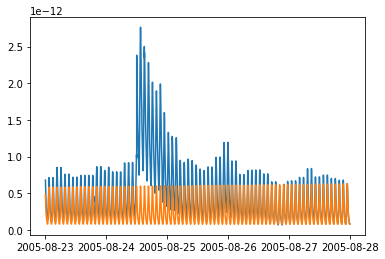

In [21]:
plt.figure()
plt.plot(Data_JB['rho'])
plt.plot(Data_JB_qt['rho'])